# Introduction to Programming and Numerical analysis
### Project 1 - analysis of C25 intraday stocks trades in week 12
 
##### The project:
In this project, we analyse the intraday trades with stock from the Danish C25 stock index. First, we will go through how we obtained the data. Then we visualize the data with interactive plots, and lastly, we examine the inttaday fluctuations.

##### Data:
 The data used for the anaylys is obtain by scraping [Nordnet](http://www.nordnet.dk/). For every Nordic stock, Nordnet provides data on buyer, seller, quantity, price and time of purchase. However, Nordnet doesn’t have a database with the data and they do not store it. Therefore, it has been necessary to run the scraper everyday when the stock market closed as the days data was deleted the following morning. The code for the developed scraped is provided below.

## The scraper

In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
from datetime import datetime, timedelta

def nordnet_scraper(identifier, marketplace, save_path = None): 
    
    """ 
    Function to download daily trades from Nordnet from specific
    stock. At the moment, Nordnet is reconstructing their website,
    so if this function doesn’t work, it could be due to a new 
    website layout.
    
    The scraper is developed for a project in "Introduction to Programming 
    and Numerical analysis" at Copenhagen University.
    
    If Nordnet doesn’t provides daily trade for a stock,
    the data is collected from the graph. This means that there
    is no data on buyer and seller, but simply the volumne and 
    price to a specific time.
    """
    
    # Check if input 'identifier' is a list
    
    if (isinstance(identifier, list)) == False:
        raise ValueError('"identifier" must be a list! Ex. ["3200"]')

    # Check if input 'marketplace' is a list
    
    if (isinstance(marketplace, list)) == False:
        raise ValueError('"marketplace" must be a list! Ex. ["14"]')
        
    # Loop over pairs of identifier and marketplace
    
    for s, t in zip(identifier, marketplace):
        
        # Start timer to measure scraping time for each stock
    
        start = time.time()
        Date = datetime.today().strftime('%Y-%m-%d')
        
        # Creating the URL to Nordnet

        base_ = 'https://www.nordnet.dk/mux/popups/marknaden/aktiehemsidan/avslut.html?containerid=avslut&identifier=' 
        identifier_ = s
        mid_ = '&marketplace='
        marketplace_ = t
        end_ = '&limit=100000'
        url = base_ + identifier_ + mid_ + marketplace_ + end_
        
        # Request to Nordnet
        
        response = requests.get(url)
        html = response.text
        soup = BeautifulSoup(html,'html.parser')
        
        # Get theStock name
        
        Stock = soup.find('h1').text.strip().lstrip().replace('\n','').replace('/',' ')
        
        # If the stock name is 'Information', then the identifier or marketsplace
        #is wrong
        
        if Stock == 'Information':
            raise ValueError('The information placed in "identifier"',
                  'and/or "marketplace" does not correspond',
                  'to any stock at Nordnet')
        
        # Get trade prices
        
        x = soup.find_all('span', {'class': ['kursPlus','kursNeutral','kursMinus']})
        price = [i.text.strip() for i in x]
        
        # If the lenght of "price" is zero, then Nordnet doesn't provide
        # daily trade dato for the stock. Instead, the data is collected
        # from the graph.
        
        if len(price) == 0:
            
            # Creating new URL to Nordnet
            
            base_ = 'https://www.nordnet.dk/graph/instrument/'
            marketplace_ = t + '/'
            identifier_ = s + '?from='
            date = Date + '&to=' + Date
            end_ = '&fields=last,open,high,low,volume'
            url = base_ + marketplace_ + identifier_+ date + end_
            
            # New request to Nordnet for graph data
            
            response = requests.get(url)
            df = pd.DataFrame(response.json())
            
            # Create DataFrame and drop unwanted variables
            
            df.drop({'high','low', 'open'}, axis = 1, inplace = True)
            df.columns = ['Price', 'Time', 'Quantity']
            
            # Convert MS to time and date
            
            df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.0))
            
            # Print message
            
            print("Nordnet doesn’t provide data for each trade",
                  "for this stock. This data is collected from the",
                  "daily graph instead.")
        
        else:
            """
            This code get the daily trade when Nordnet provides them
            """
            
            # Get time of trade
            
            x = soup.find_all('td', {'class': 'last'})
            time_ = [i.text.strip() for i in x]
            
            # Get seller and buyer
            
            x = soup.find_all('a', {'class': 'underline'})
            firms = [i.attrs['title'] for i in x]
            buyer_ = firms[::2]
            seller_ = firms[1::2]
            
            # get traded quantity
            
            quan = soup.find_all('td')
            x = quan[2::5]
            quantity = [i.text for i in x]
            
            # create df
            
            df = pd.DataFrame(list(zip(buyer_, seller_, quantity, price, time_)),
                              columns = ['Buyer', 'Seller', 'Quantity','Price', 'Time'])
            
            # data mining
            
            df['Quantity'] = pd.to_numeric(df['Quantity'].str.replace(" ", ""))

            try:
                df['Price'] = df['Price'].str.replace(" ", "")
            except:
                pass
            try:
                df['Price'] = df['Price'].str.replace(",", ".")
            except:
                pass
            
            df['Price'] = pd.to_numeric(df['Price'])
            
            # If the scraper is used in the weekend, friday trades appear.
            # Check if weekend
            
            weekday = datetime.today().weekday()
            
            # if saturday, then friday
            
            if weekday == 5:
                Date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
            
            # if sunday, then friday
            
            if weekday == 6:
                Date = (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d')
            
            # Create correct format for time variable  
            
            df['today'] = Date + ' ' + df['Time']
            df['Time'] = df['today'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
            df = df.drop(columns='today')
            
        # Get HH:MM to display on graph
        
        df['TimeStamp'] = pd.Series([val.time() for val in df['Time']])
        
        # Plotting the trades
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.plot_date(df['Time'], df['Price'], ls='-', marker= None, color = 'blue')
        ax.set_title(Stock + ', ' + Date)
        ax.set_ylabel('Price')
        ax.set_xlabel('Time') 
        ax.grid(True)
        fig.tight_layout()
        
        # Saving DataFrame to CSV file
        
        if save_path != 0:
            # Save to csv file
            path = save_path
            link_name = Date + ' ' + Stock
            end_ = '.csv'
            link = path + link_name + end_
            try:
                df.to_csv(link)
            except:
                raise ValueError('Error saving file. Check path!')   
            
        # End timer and print total time
        
        end = time.time()
        print(round(end - start,1),'secs to return', len(df), 'trades of', Stock)
    
    # Return DataFrame
    
    return df

## Data mining

Each stock’s URL on Nordnet has a unique combination of *identifier* and *marketplace*, which is used in the scraper-function. The combinations for the C25-index is listed below.

In [ ]:
identifier = ['3200','3201','3331','1596','75663',
              '3203','1586','3415','3207','11143',
              '3205','80901','1587','3853','1158',
              '11273','77855','3456','3273','4806',
              '3366','31315','3258','3247','122544']

marketplace = ['14','14','14','14','14',
               '14','14','14','14','14',
               '14','14','14','14','14',
               '14','14','14','14','14',
               '14','14','14','14','14']

df = nordnet_scraper(identifier, marketplace, 'YOUR FOLDER')

We now have 125 files as we have intraday trade data for 25 stocks and 5 days. To get it all into one DataFrame, we run the following code

In [ ]:
import glob

path = r'YOUR FOLDER'
all_files = glob.glob(path + "/*.csv")

names = []

for i in all_files:
    name = " ".join(i.split()[1:]).split("·")[0]
    names.append(name)

li = []

for idx, val in enumerate(all_files):
    df = pd.read_csv(val, index_col=None, header=0, engine='python')
    df['stock'] = names[idx]
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

frame.to_csv(r'YOUR FOLDER', encoding='latin-1')

The final output is a dataset with 364.848 rows and 9 columns

In [5]:
data = pd.read_csv(r'data.csv', encoding='latin-1')

# Changing the names of 2 of the ID-rows
data.rename(columns = {'Unnamed: 0':'ID', 'Unnamed: 0.1':'ID_within_firm'}, inplace=True)

# print
print(data.head(3))
print(data.shape)

   ID  ID_within_firm                   Buyer            Seller  Quantity  \
0   0               0  Enskilda Securities AB  Anonymous Broker         1   
1   1               1  Enskilda Securities AB  Anonymous Broker        34   
2   2               2  Enskilda Securities AB  Anonymous Broker        79   

    Price                 Time TimeStamp                      stock  
0  8395.0  2019-03-18 16:59:31  16:59:31  A.P. Møller - Mærsk A A S  
1  8395.0  2019-03-18 16:59:31  16:59:31  A.P. Møller - Mærsk A A S  
2  8395.0  2019-03-18 16:59:31  16:59:31  A.P. Møller - Mærsk A A S  
(364848, 9)


## Interactive plot

In order to get an overview of how the price of the different stocks in C25 have develop throughout the week, we make an interactive plot that display the price of the stock as a function of time.  

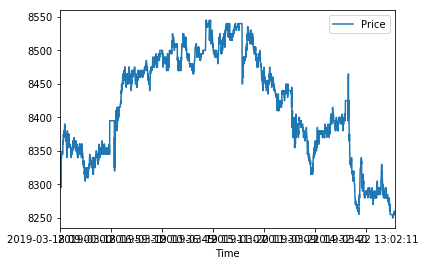

In [6]:
# Sort data
data.sort_values(['stock','Time'], inplace=True) 

# Make an interactive plot
import ipywidgets as widgets
def plot(dataframe, stock): 
    I = dataframe['stock'] == stock
    
    ax=dataframe.loc[I,:].plot(x='Time', y='Price', style='-', legend='False')

    
widgets.interact(plot, 
    dataframe = widgets.fixed(data),
    stock = widgets.Dropdown(description='stock', options=data.stock.unique(), value='A.P. Møller - Mærsk A A S')
); 

From the plot above it is clear that, within week 12, the fluctuations in the price are substantial across the different stocks. As our data contains all executed trades in the C25-index in week 12 we would like to illustrate the daily fluctuations in the price of each stock. For that reason we add a "day-drop" to the interactive plot.    

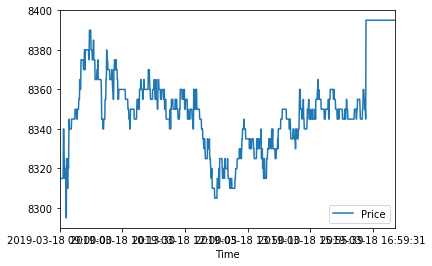

In [7]:
# Create a column which contain the name of the day the given trade was executed
data['Day_of_Week'] = pd.to_datetime(data['Time']).dt.weekday_name

# Make an interactive plot with a "stock" and "day" dropdown
def plot_e(dataframe, stock, Day_of_Week): 
    
    I = (dataframe['stock'] == stock) & (dataframe['Day_of_Week'] == Day_of_Week)
    
    ax=dataframe.loc[I,:].plot(x='Time', y='Price', style='-', legend='False')
    
widgets.interact(plot_e, 
    dataframe = widgets.fixed(data),
    stock = widgets.Dropdown(description='Stock', options=data.stock.unique(), value='A.P. Møller - Mærsk A A S'),
    Day_of_Week = widgets.Dropdown(description='Day_of_Week', options=data.Day_of_Week.unique(), value='Monday'),
);

NB: There are a few extreme observations (outliers) in the data of a couple of stocks. We will make a comment on that in the next section. Also, due to the extrodinary event that William Demant Holding A/S chose to shorten their name to Demant A/S there are 26 stocks in the dropdown menu. Hence, William Demant Holding A/S only contains data for Monday, Tuesday and Wednesday while Demant A/S contains data for Thursday and Friday.

## Fluctuations analysis

In this section, we will analyze the fluctuations in the prices of the stocks listed on C25.
The aim of this analysis is to get a rough estimate of the importance of executing buyings or sellings at the right point of the day. We will calculate the average fluctuation in the price for each of the days for each of the stocks, and hence we will find the overall average. By including all of the stocks on C25 in an arbitrary week, we try to mitigate the risk of having the price pattern too much controlled by special events for one or more of the companies.

In [6]:
#Convert the Time-column to a datevariable 
data['Time'] = pd.to_datetime(data['Time']) 

#Set 'Time' as index-variable
data = data.set_index('Time')

In order to get an overview of the fluctuations in the stock prices during a day, we will have to define the upper and lower bounds of the trading price for each of the C25 stocks.
Hence, e.g. on Monday 18th, we are interested in the highest price and the lowest price e.g. the A.P. Møller Mærsk stock has been traded at. For each of the stocks, we will then get a max-price and a min-price for each of the days in the week. In addition, we will find the mean price.

In [7]:
# Generate new variable which holds the mean of the price for the individual stock for each day in the week
data_grouped_mean = data['Price'].groupby([data.stock, data.index.dayofweek, data.index.day]).mean()
print(data_grouped_mean.head(10))

# Generate new variable which holds the lowest price the stock has been traded for during the day. (For Monday-Friday) 
data_grouped_min = data['Price'].groupby([data.stock, data.index.dayofweek, data.index.day]).min()
print(data_grouped_min.head(10))

# Generate new variable which holds the highest price the stock has been traded for during the day. (For Monday-Friday)
data_grouped_max = data['Price'].groupby([data.stock, data.index.dayofweek, data.index.day]).max()
print(data_grouped_max.head(10))

stock                      Time  Time
A.P. Møller - Mærsk A A S  0     18      8349.733645
                           1     19      8489.071543
                           2     20      8463.858921
                           3     21      8379.468412
                           4     22      8292.653552
A.P. Møller - Mærsk B A S  0     18      8751.276428
                           1     19      8910.696317
                           2     20      8889.437338
                           3     21      8792.056856
                           4     22      8719.856735
Name: Price, dtype: float64
stock                      Time  Time
A.P. Møller - Mærsk A A S  0     18      8295.0
                           1     19      8320.0
                           2     20      8410.0
                           3     21      8315.0
                           4     22      8250.0
A.P. Møller - Mærsk B A S  0     18      8686.0
                           1     19      8749.0
                           2  

From the sample print, we can see e.g. that the mean price of A.P. Møller Mærsk A was 8,349 dkk on Monday 18th, whereas the highest price was 8,395 dkk and the lowest price was 8,295 dkk.

In the following, we will calculate the percentage difference between the highest and the lowest price in order to understand what it might potentially imply for the individual investor.

In [8]:
# Calculate percentage difference between the lowest trading price during the day and the highest trading price during the day
diff_max_min = ((data_grouped_max)-(data_grouped_min))/(data_grouped_min)*100

# Print example on the change in prices during a day
print(diff_max_min.head(10))

stock                      Time  Time
A.P. Møller - Mærsk A A S  0     18      1.205546
                           1     19      2.704327
                           2     20      1.486326
                           3     21      1.563440
                           4     22      2.606061
A.P. Møller - Mærsk B A S  0     18      1.243380
                           1     19      2.526003
                           2     20      1.745636
                           3     21      1.741522
                           4     22      2.606690
Name: Price, dtype: float64


Thus, the highest price tag for the A.P. Møller Mærsk A stock during the day on Monday the 18th was 1,2 % higher than the lowest price tag during the day.

In order to get a rough estimate for the general fluctuation during the day, we will calculate the mean of percentage differences between all the days and all the C25 stocks.

In [9]:
# Mean of daily percentage difference between lowest and highest price between all days in week 12 and all C25 companies
print(diff_max_min.mean())

2.5321427794413625


This result shows that for the C25 stocks in week 12, the highest trading price for a stock during a day is on average 2,53 % higher than the lowest trading price on the same day.

This result cannot in any way guide the investor on when to execute planned trades, however, the result clarifies that it is definitely worth considering when to execute the trade.

However, a few outliers gives this estimate an upwards biases. A few transactions within financial institutions shows price tags varying quite a lot from the market price, which results in a seemingly bigger difference between lowest and highest trading price.